In [15]:
import os
import shutil
import vcf
import re
import gzip
import pandas as pd
import yaml
import subprocess
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import numpy as np
#from IPython.display import Image
#from Bio import SeqIO
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess


#import rpy2.ipython


#%load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

# Linkage Disequilibrium

In [6]:
if not os.path.isdir("results/ld"):
    os.mkdir("results/ld")

Read in population assignment and create (new) list files

In [7]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)

In [8]:
for pop in set(pop_assign.values()):
    list_file = "results/ld/{}.list".format(pop);
    if os.path.exists(list_file):
        os.remove(list_file)
    
for sample in pop_assign:
   
    pop=pop_assign[sample]
    list_file="results/ld/" + pop + ".list"
    with open(list_file, 'a') as filehandle:
        filehandle.write("{}\n".format(sample))

## Calculate R2 with VCFtools and Plink

In [9]:
in_vcf="results/variant_filtration/smv7_ex_autosomes.vcf"

for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)
    in_list = "results/ld/{}.list".format(pop)
    
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        out_vcf = "results/ld/smv7_ex_autosomes_{}_{}.vcf".format(pop, chrom)
        
        #get ld chrom vcf
        vcf_cmd="vcftools --vcf {} --maf 0.05 --chr {} --keep {} --recode --recode-INFO-all --stdout >{}".format(in_vcf, chrom, in_list, out_vcf)
        !{vcf_cmd}

        #convert vcf to plink
        plink_prefix="results/ld/smv7_ex_autosomes_{}_{}".format(pop, chrom)
        plink_cmd="plink --threads 6 --vcf {} --out {} --double-id --recode12 --allow-extra-chr".format(out_vcf, plink_prefix)
        !{plink_cmd}  
        
        #calculate R2 between all snps on a chr
        plink_cmd="plink --threads 6 --r2 --file {} --out {} --double-id --allow-extra-chr --ld-window-r2 0.0 --ld-window 1000000 --ld-window-kb 1000".format(plink_prefix, plink_prefix)
        !{plink_cmd}


senegal
PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to results/ld/smv7_ex_autosomes_senegal_SM_V7_1.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out results/ld/smv7_ex_autosomes_senegal_SM_V7_1
  --recode 12
  --threads 6
  --vcf results/ld/smv7_ex_autosomes_senegal_SM_V7_1.vcf

128540 MB RAM detected; reserving 64270 MB for main workspace.
--vcf: results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.bed +
results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.bim +
results/ld/smv7_ex_autosomes_senegal_SM_V7_1-temporary.fam written.
2680 variants loaded from .bim file.
25 people (0 males, 0 females, 25 ambiguous) loaded from .fam.
Ambiguous sex IDs written to results/ld/smv7_ex_autosomes_senegal_SM_V7_1.nosex
.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filte

Make new files that contain all R2 info from Plink, but also add distance between SNP-A and SNP-B. 

In [10]:
#create tables
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    print(pop)
    
    in_list = "results/ld/{}.list".format(pop)
    
    #open the outfile that will contain ALL of the data (and add a header)
    with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'w') as merged_all_out_file:
        #print header line
        header_line="chr_a\tbp_a\tsnp_a\tchr_b\tbp_b\tsnp_b\tr2\ta_b_dist\n"
        merged_all_out_file.write(header_line)
        
        #open each chrom specific ld file (and skip the header)
        for chrom in list(range(1, 8)):
            chrom="SM_V7_{}".format(chrom)
            plink_file="results/ld/smv7_ex_autosomes_{}_{}.ld".format(pop, chrom)

            with open(plink_file, 'r') as in_file:
                next(in_file)

                #for each r2 calc
                for entry in in_file:
                    entry=','.join(entry.split())
                    chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2 = entry.split(",")

                    #calculate the distance between the snps
                    a_b_dist = int(bp_b) - int(bp_a)
                    outline=[chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, str(a_b_dist), "\n"]
                    outline="\t".join(outline)

                    #and print to the ALL output file
                    merged_all_out_file.write(outline)

senegal
niger
brazil
tanzania


In [11]:
#clean up all of the unused files
for pop in ["senegal", "niger", "brazil", "tanzania"]:
    for chrom in list(range(1, 8)):
        chrom="SM_V7_{}".format(chrom)
        for ext in ["ld", "map", "ped", "log", "nosex", "vcf"]:
            file_to_del="results/ld/smv7_ex_autosomes_{}_{}.{}".format(pop, chrom, ext)
            if os.path.exists(file_to_del):
                os.remove(file_to_del)

## Calc. mean R2 values per bin/distance

In [82]:
# #read in plink R2 data and create a df to save
# dists=defaultdict(lambda: list())
# r2s=defaultdict(lambda: list())

# for pop in ["niger", "senegal", "brazil", "tanzania"]:
#     print(pop)

#     with open("results/ld/smv7_ex_autosomes_{}_dist.tbl".format(pop), 'r') as in_file:
#         #skip header line
#         next(in_file)

#         for entry in in_file:
#             chr_a, bp_a, snp_a, chr_b, bp_b, snp_b, r2, a_b_dist = entry.rstrip().split("\t")
#             r2s[pop].append(float(r2))
#             dists[pop].append(int(a_b_dist))

# #convert to np array
# for pop in ["niger", "senegal", "brazil", "tanzania"]:
#     dists[pop]=np.array(dists[pop])
#     r2s[pop]=np.array(r2s[pop])

    
#create bins for stat binning
bins=np.geomspace(1, 1_000_000, num=1000)

#get mean values for each bin
n, bin_edges, binnumber=stats.binned_statistic(dists["niger"], r2s["niger"], statistic='mean', bins=bins)
b, bin_edges, binnumber=stats.binned_statistic(dists["brazil"], r2s["brazil"], statistic='mean', bins=bins)
s, bin_edges, binnumber=stats.binned_statistic(dists["senegal"], r2s["senegal"], statistic='mean', bins=bins)
t, bin_edges, binnumber=stats.binned_statistic(dists["tanzania"], r2s["tanzania"], statistic='mean', bins=bins)

#save data to a csv for ease of access later
df=pd.DataFrame(data=[bin_edges[:-1], n, b, s, t]).T.dropna()
df.columns=["distance_bin", "niger_r2", "brazil_r2", "senegal_r2", "tanzania_r2"]
df.to_csv("results/ld/ld_dist_binned_smoothed_pybins.csv", sep=",")
# df

# Plot

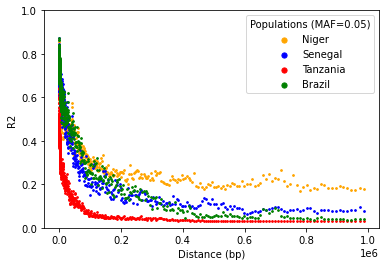

In [136]:
plt.scatter(df["distance_bin"], df["niger_r2"],    s=3, c="orange",    label="Niger")
plt.scatter(df["distance_bin"], df["senegal_r2"],  s=3, c="blue", label="Senegal")
plt.scatter(df["distance_bin"], df["tanzania_r2"], s=3, c="red",  label="Tanzania")
plt.scatter(df["distance_bin"], df["brazil_r2"],   s=3, c="green",   label="Brazil")
plt.xlabel("Distance (bp)")
plt.ylabel("R2")
#plt.xscale('log')
plt.ylim(0,1)
#plt.xlim(0,10)
plt.legend(title="Populations (MAF=0.05)", markerscale=3)

plt.savefig("results/ld/ld_decay_maf05.svg")
plt.savefig("results/ld/ld_decay_maf05.png")

plt.show()
plt.close()

Tanzania: 20932.727559814048
Brazil: 67106.35047355217
Senegal: 45939.14160260646
Niger: 48795.51279463482


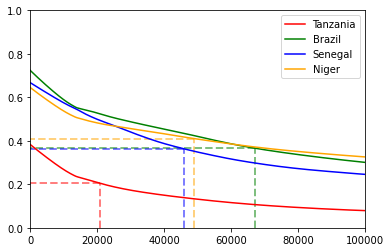

In [137]:
x=bin_edges[1:]

for y, label, color in [(t, "Tanzania", "red"), 
                 (b, "Brazil", "green"),
                 (s, "Senegal", "blue"),
                 (n, "Niger", "orange")]:

    #plot
    #plt.scatter(x, y, s=10, alpha=0.1, c=color)
    
    #smooth
    l=lowess(y, x, frac=0.66)
    xl=l[:,0]
    yl=l[:,1]
    plt.plot(xl, yl, label=label, c=color)
    
    #get ld50
    decay = interp1d(yl, xl, bounds_error=False)
    
    #what point is Ld50 In 250kb
    #OVER A MB ld=yl[0] - ((yl[0]-yl[x==x[-1]])/2)
    ld=yl[0] - ((yl[0]-yl[-1])/2)
    ld50=decay(ld)
    
    #add line to chart
    plt.vlines(ld50, 0, ld, colors=color, linestyle='dashed', linewidth=2, alpha=0.5)
    plt.hlines(ld, ld50, ld, colors=color, linestyle='dashed', linewidth=2, alpha=0.5)

    print("{}: {}".format(label, ld50))

plt.ylim(0,1)
plt.xlim(0,100_000)
plt.legend()
#plt.xscale('log')
plt.savefig("results/ld/ld50_maf05.svg")
plt.savefig("results/ld/ld50_maf05.png")
plt.show()


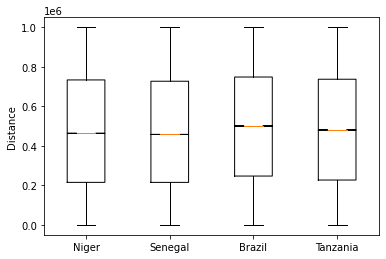

In [249]:
plt.boxplot([ dists["niger"][r2s["niger"]<0.2],
              dists["senegal"][r2s["senegal"]<0.2],
              dists["brazil"][r2s["brazil"]<0.2],
              dists["tanzania"][r2s["tanzania"]<0.2] ],
            showfliers=False, 
            notch=True,
            labels=["Niger", "Senegal", "Brazil", "Tanzania"])
plt.ylabel("Distance")
plt.show()